In [1]:
#!/usr/bin/env python
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pprint
import json

import numpy as np
import pandas as pd
import obspy
import math

import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl
import time

from matplotlib.colors import ListedColormap
plt.rcParams["figure.figsize"]= (15,15)
from matplotlib import rcParams, cycler
import matplotlib.colors as colors
from matplotlib import cm


import sys
import os
ISCOLAB = 'google.colab' in sys.modules

import random
import json
import pprint
from obspy import Stream, Trace, UTCDateTime
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

base_dir = 'F:\Thesis_ssd\MasterThesis3.0'
os.chdir(base_dir)

from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.DataProcessing.TimeAugmentor import TimeAugmentor
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Modeling.ResultFitter import ResultFitter
from Classes.Modeling.NarrowSearch import NarrowSearch
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
import json

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#%matplotlib notebook

### Loading data:


In [2]:
### Data conditions: ###
load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : False,
    'downsample' : False,
    'upsample' : False,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 1,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'load_everything' : True
}

loadData = LoadData(**load_args)
handler = DataHandler(loadData)

full_ds = loadData.full_ds

In [3]:
def path_to_info(path):
    with h5py.File(path, 'r') as dp:
        info = np.array(dp.get('event_info'))
        info = json.loads(str(info))
    return info


def progress_bar(current, total, barLength = 40):
    percent = float(current) * 100 / total
    arrow   = '-' * int(percent/100 * barLength - 1) + '>'
    spaces  = ' ' * (barLength - len(arrow))
    print('Creating info: [%s%s] %d %%' % (arrow, spaces, percent), end='\r')
    
def paths_to_coords(ds):
    paths = ds[:,0]
    n = len(paths)
    path_coords = {}
    for i, path in enumerate(paths):
        with h5py.File(path, 'r') as dp:
            info = np.array(dp.get('event_info'))
            info = json.loads(str(info))
            lat = info['origins'][0]['latitude']
            lon = info['origins'][0]['longitude']
            mag = info['magnitudes'][0]['mag']
            msrdr = info.get('magnitude_sqrtdist_ratio')
            event_type = info['event_type']
            path_coords[path] = {'lat' : lat, 'lon' : lon, 'mag' : mag, 'msrdr' : msrdr, 'event_type' : event_type}
            progress_bar(i+1, n)
    return path_coords
    
    
def lons_lats_mags_labels(paths_coords):
    lons = []
    lats = []
    mags = []
    msrdr = []
    labels = []
    for event in paths_coords:
        lats.append(paths_coords[event]['lat'])
        lons.append(paths_coords[event]['lon'])
        mags.append(paths_coords[event]['mag'])
        msrdr.append(paths_coords[event]['msrdr'])
        labels.append(paths_coords[event]['event_type'])
    return lons, lats, mags, msrdr, labels

In [4]:
earthquakes = full_ds[full_ds[:,1] == "earthquake"]
explosions = full_ds[full_ds[:,1] == "explosion"]

earth_coords = paths_to_coords(earthquakes)


earth_lons, earth_lats, earth_mags, earth_msrdrs, earth_labels = lons_lats_mags_labels(earth_coords)


In [8]:
explo_coords = paths_to_coords(explosions)

In [ ]:
explo_lons, explo_lats, explo_mags, explo_msrdrs, explo_labels = lons_lats_mags_labels(explo_coords)

## Drawing Scandinavia

In [5]:
m = Basemap(projection="stere", 
            width=4.5E6,
            height=4.5E6,
            lat_ts=68,
            lat_0=68,
            lon_0=16,
            resolution = 'h')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


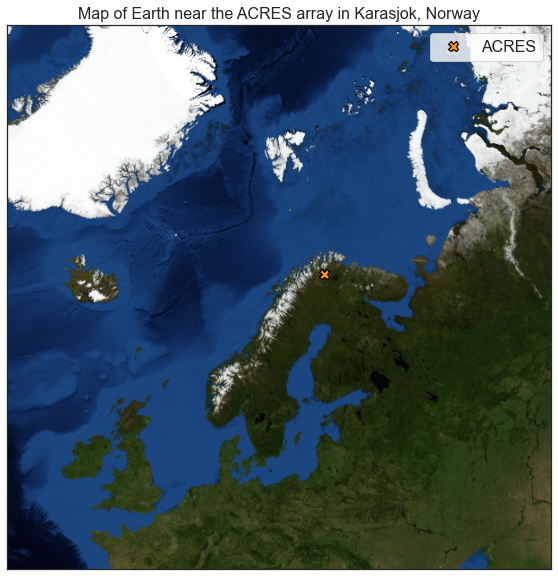

In [6]:
#m.drawcoastlines()
#m.drawcountries()
#m.drawrivers()
#m.fillcontinents()
#m.etopo()
m.bluemarble()
#m.drawmapboundary(fill_color='aqua')
plt.title('Map of Earth near the ACRES array in Karasjok, Norway')
lat_kara = 69.4719
lon_kara = 25.5108
x, y = m(lon_kara, lat_kara)
m.plot(x, y, 'X', color=(1,0.6,0,1), markersize = 10,  markeredgewidth=1.2, markeredgecolor=(0, 0, 0, 1), 
           label = 'ACRES')
plt.legend()

plt.show()

### Drawing ACRES events

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


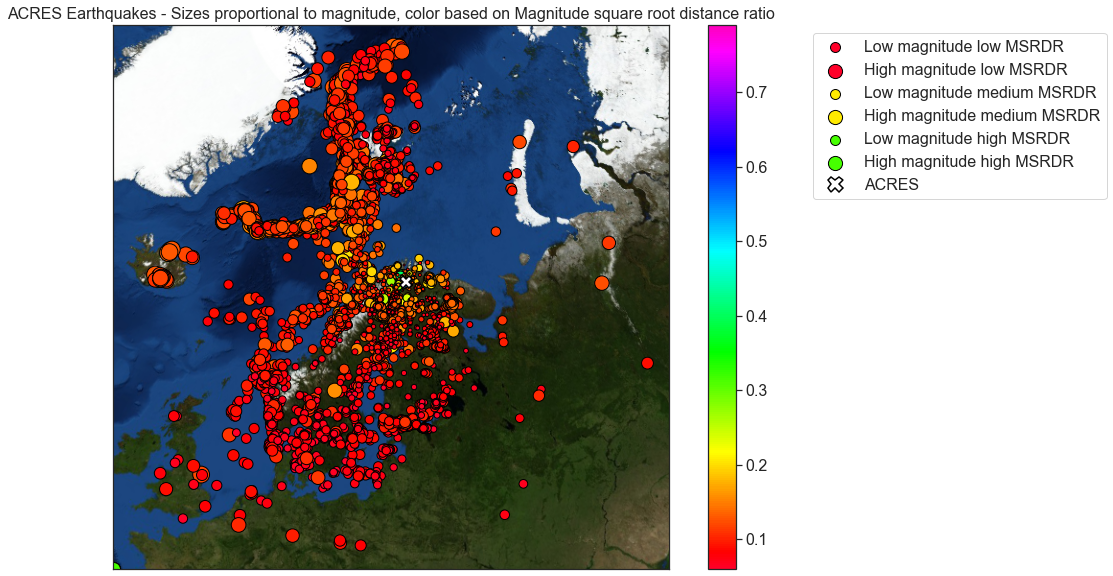

In [7]:
a = Basemap(projection="stere", 
            width=4.3E6,
            height=4.2E6,
            lat_ts=68.4719,
            lat_0=68.4719,
            lon_0=22.5108,
            resolution = 'f')
a.bluemarble()

#x_explo, y_explo = a(explo_lons, explo_lats)
x_earth, y_earth = a(earth_lons, earth_lats)

earth_l_msrd = [x for x in earth_msrdrs]

colormap = plt.cm.gist_rainbow
normalize = colors.Normalize(vmin=min(earth_l_msrd), vmax = max(earth_l_msrd))

plt.scatter(x_earth, 
            y_earth, 
            s = [(x*3)**2 for x in earth_mags], 
            c = earth_l_msrd, 
            marker = 'o', 
            cmap=colormap, 
            norm = normalize, 
            edgecolor=(0, 0, 0, 1), 
            label = 'Earthquake')
"""
for x1, y1, mag, msrdr in zip(x_earth,y_earth, earth_mags, earth_msrdrs):
    plt.scatter(x1, y1, 'o', markersize = mag*3, 
           c = c, s = msrdr, cmap="RdPu",
           markeredgewidth=1.2, markeredgecolor=(0, 0, 0, 1), 
           label = 'Earthquake')
"""
lat_kara = 69.4719
lon_kara = 25.5108


x, y = a(lon_kara, lat_kara)
a.plot(x, y, 'X', color='white', markersize = 12,  markeredgewidth=1.5, markeredgecolor=(0, 0, 0, 1), 
           label = 'ACRES')
plt.title('ACRES Earthquakes - Sizes proportional to Magnitude, color based on Magnitude square root distance ratio')

small  = 100
large = 200
custom_scatter = [plt.scatter([0],[0], color=colormap(0.), s = small, edgecolor = (0,0,0,1)),
                  plt.scatter([0],[0], color=colormap(0.), s = large, edgecolor = (0,0,0,1)),
                  plt.scatter([0],[0], color=colormap(0.2), s = small, edgecolor = (0,0,0,1)),
                  plt.scatter([0],[0], color=colormap(0.2), s = large, edgecolor = (0,0,0,1)),
                  plt.scatter([0],[0], color=colormap(0.35), s = small, edgecolor = (0,0,0,1)),
                  plt.scatter([0],[0], color=colormap(0.35), s = large, edgecolor = (0,0,0,1)),
                  plt.Line2D([0],[0],marker='X', color='white', markersize = 15,  markeredgewidth=1.5, markeredgecolor=(0, 0, 0, 1))]
plt.legend(custom_scatter, 
           ["Low magnitude low MSRDR", 
            "High magnitude low MSRDR", 
            "Low magnitude medium MSRDR", 
            "High magnitude medium MSRDR",
            "Low magnitude high MSRDR", 
            "High magnitude high MSRDR", 
            "ACRES"],
          loc='upper right',
          bbox_to_anchor=(1.8, 1))

plt.colorbar( cm.ScalarMappable(norm=normalize, cmap = colormap))
plt.show()

In [138]:
c = Basemap(projection="stere", 
            width=4.5E6,
            height=4.5E6,
            lat_ts=69,
            lat_0=69.47,
            lon_0=16,
            resolution = 'i')

#x_explo, y_explo = c(explo_lons, explo_lats)
x_earth, y_earth = c(earth_lons, earth_lats)

c.drawcoastlines()
c.drawcountries()

#for x1, y1, s in zip(x_explo,y_explo, explo_mags):
#    c.plot(x1, y1, 'ro', markersize = s*5, color='r', label = 'Explosion')

for x1, y1, s in zip(x_earth,y_earth, earth_msrdrs):
    c.plot(x1, y1, 'o', markersize = s*80, 
           color = (1,0.1,0.1,0.9), 
           markeredgewidth=1.2, markeredgecolor=(0, 0, 0, 1), 
           label = 'Earthquake')
    
plt.title('ACRES Earthquakes - Sizes proportional to magnitude square root distance ratio')
plt.show()

KeyboardInterrupt: 

In [48]:
max(earth_msrdrs)

0.789717329282861

In [49]:
min(earth_msrdrs)

0.06003749403279082

In [53]:
np.log10(max(earth_msrdrs))

-0.34059174617770588

In [146]:
x

2619542.228962702

In [147]:
y

2442327.837105369